# Random vs. Feedback Noise

Does the increasing FPR observed in experiments depend on the fact that we are using the model's predictions to perturb labels? What if we just randomly perturb labels during training according to a model's initial FPR? Would the same increase in FPR be observed?

In [2]:
import copy
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import torch

import sklearn.linear_model as linear_model

from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from utils import eval_model, perturb_labels_fp, update_model_online_noise, update_model_online_feedback, make_gaussian_data

%matplotlib inline

## Random Label Perturbation

In [10]:
seeds = np.arange(1000)
initial_fprs = []
updated_fprs = []

for seed in seeds:
    np.random.seed(seed)

    x, y = make_classification(100000, n_informative=2, n_features=2, n_classes=2, n_clusters_per_class=2 ,n_redundant=0, flip_y=0, class_sep=1.0)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.9)
    x_update, x_test, y_update, y_test = train_test_split(x_test, y_test, test_size=0.5)
    
    model = linear_model.SGDClassifier(max_iter=10000, tol=1e-3, warm_start=True, loss="log")
    model.fit(x_train, y_train)
    
    y_pred = model.predict(x_test)
    initial_tnr, initial_fpr, initial_fnr, initial_tpr = eval_model(y_test, y_pred)
    
    new_model = update_model_online_noise(model, x_update, y_update, 100, initial_fpr)
    
    y_pred = new_model.predict(x_test)
    updated_tnr, updated_fpr, updated_fnr, updated_tpr = eval_model(y_test, y_pred)
    
    initial_fprs.append(initial_fpr)
    updated_fprs.append(updated_fpr)

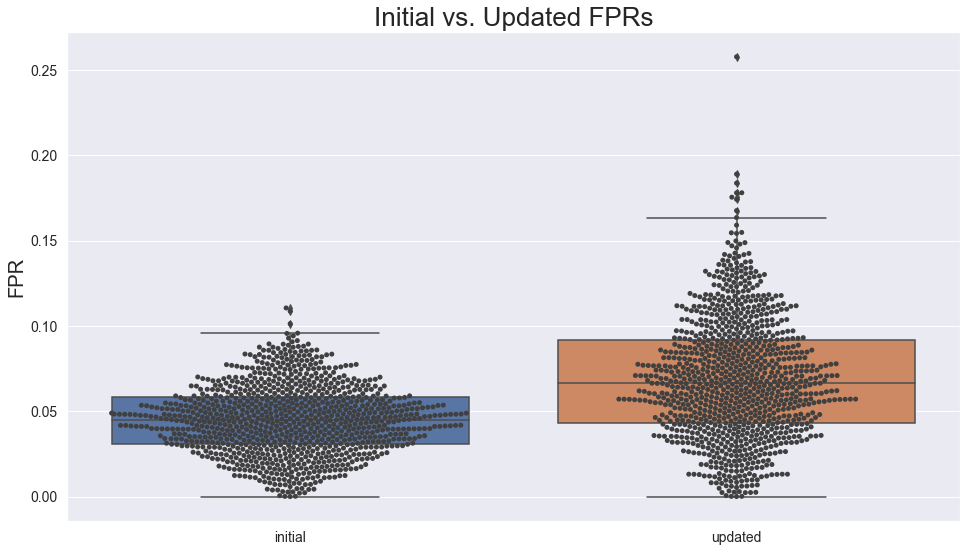

In [11]:
fprs = {"type": (["initial"] * len(initial_fprs)) + (["updated"] * len(updated_fprs)),
        "fpr": initial_fprs + updated_fprs}
data = pd.DataFrame(fprs)
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
sns.boxplot(x="type", y="fpr", data=data, ax=ax)
sns.swarmplot(x="type", y="fpr", data=data, color=".25", ax=ax)
ax.set_xlabel("")
ax.set_ylabel("FPR", size=20)
ax.set_title("Initial vs. Updated FPRs", size=26)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

## Feedback Label Perturbation

In [8]:
seeds = np.arange(1000)
initial_fprs = []
updated_fprs = []

for seed in seeds:
    np.random.seed(seed)

    x, y = make_classification(100000, n_informative=2, n_features=2, n_classes=2, n_clusters_per_class=2 ,n_redundant=0, flip_y=0, class_sep=1.0)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.9)
    x_update, x_test, y_update, y_test = train_test_split(x_test, y_test, test_size=0.5)
    
    model = linear_model.SGDClassifier(max_iter=10000, tol=1e-3, warm_start=True, loss="log")
    model.fit(x_train, y_train)
    
    y_pred = model.predict(x_test)
    initial_tnr, initial_fpr, initial_fnr, initial_tpr = eval_model(y_test, y_pred)
    
    new_model = update_model_online_feedback(model, x_update, y_update, 100)
    
    y_pred = new_model.predict(x_test)
    updated_tnr, updated_fpr, updated_fnr, updated_tpr = eval_model(y_test, y_pred)
    
    initial_fprs.append(initial_fpr)
    updated_fprs.append(updated_fpr)

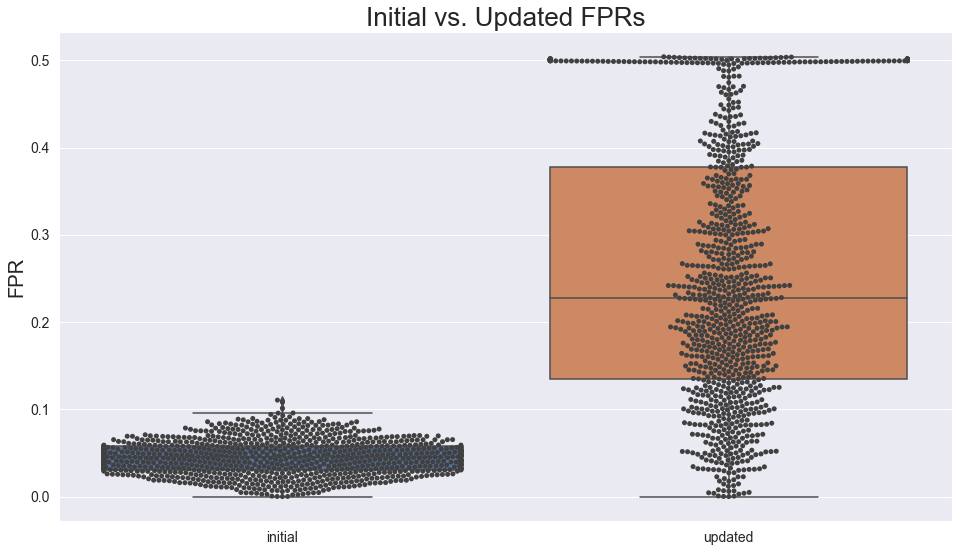

In [9]:
fprs = {"type": (["initial"] * len(initial_fprs)) + (["updated"] * len(updated_fprs)),
        "fpr": initial_fprs + updated_fprs}
data = pd.DataFrame(fprs)
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
sns.boxplot(x="type", y="fpr", data=data, ax=ax)
sns.swarmplot(x="type", y="fpr", data=data, color=".25", ax=ax)
ax.set_xlabel("")
ax.set_ylabel("FPR", size=20)
ax.set_title("Initial vs. Updated FPRs", size=26)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)